In [ ]:
# =============================================================================
# Model Selection and Hyperparameter Tuning for ECG Apnea Detection
# =============================================================================
# This script:
#   - Loads preprocessed features for different signal interval lengths (60s, 90s, 120s)
#   - Performs model selection using un-tuned classifiers via 5-fold cross-validation
#   - Tunes hyperparameters for the top three models (Linear SVM, Gradient Boosting, AdaBoost)
#   - Retrains a selected model and then reduces the feature space based on feature importance
#   - Evaluates the final model using various metrics (classification report, ROC, confusion matrix)
#
# Make sure that the feature files and "Feature Names" pickle file exist in the 
# specified directories.
#
# =============================================================================

In [3]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, 
                              HistGradientBoostingClassifier)
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.exceptions import FitFailedWarning
from sklearn.feature_selection import SelectKBest, f_classif

# ----------------------------
# Suppress Unnecessary Warnings
# ----------------------------
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FitFailedWarning)

In [ ]:
#  Model Selection: Evaluate Different Signal Intervals (60s, 90s, 120s)

for i in [60, 90, 120]:
    # Load training and testing data for the given interval
    X_train = np.load(f"Extracted Features and supplemental files/features_cleaned_{i}s_train.npy")
    y_train = np.load(f"Extracted Features and supplemental files/labels_cleaned_{i}s_train.npy")
    X_test = np.load(f"Extracted Features and supplemental files/features_cleaned_{i}s_test.npy")
    y_test = np.load(f"Extracted Features and supplemental files/labels_cleaned_{i}s_test.npy")
    
    print(f"\nTesting for {i}s intervals")
    names = [
        "Nearest Neighbors",
        "Linear SVM",
        "RBF SVM",
        "Decision Tree",
        "Random Forest",
        "AdaBoost",
        "Gradient Boosting",
        "XGBoost",
        "LGBM",
        "Extra Trees",
        "Bagging Classifier",
        "HistGradientBoosting",
        "Gaussian Naive Bayes",
        "Bernoulli Naive Bayes",
        "Quadratic Discriminant Analysis",
        "Neural Network (MLP)"
    ]
    # Define corresponding classifier objects (using default or simple hyperparameters)
    classifiers = [
        KNeighborsClassifier(3),
        SVC(kernel="linear", C=0.025, random_state=42),
        SVC(gamma=2, C=1, random_state=42),
        DecisionTreeClassifier(max_depth=5, random_state=42),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=42),
        AdaBoostClassifier(random_state=42),
        GradientBoostingClassifier(random_state=42),
        XGBClassifier(),
        LGBMClassifier(random_state=42, verbosity=-1),
        ExtraTreesClassifier(n_estimators=100, random_state=42),
        BaggingClassifier(random_state=42),
        HistGradientBoostingClassifier(random_state=42),
        GaussianNB(),
        BernoulliNB(),
        QuadraticDiscriminantAnalysis(),
        MLPClassifier(random_state=42, max_iter=1000)
    ]
    
    results = {}  # Dictionary to hold CV accuracy for each model

    # Evaluate each classifier using a pipeline with scaling and feature selection
    for name, clf in zip(names, classifiers):
        # Create pipeline with StandardScaler, SelectKBest, and the classifier
        pipe = make_pipeline(StandardScaler(), SelectKBest(score_func=f_classif, k=40), clf)
    
        # 5-fold cross-validation on training data
        scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy', error_score='raise')
        avg_cv_score = np.mean(scores)
    
        results[name] = avg_cv_score
        print(f"{name}: CV Accuracy = {avg_cv_score:.4f}")
    
    # Select best model based solely on CV accuracy
    sorted_models = sorted(results, key=lambda x: results[x], reverse=True)
    print(f"\nBest Model Selected for Tuning (based on CV): {sorted_models[0]} with CV accuracy of {results[sorted_models[0]]:.4f}")
    print(f"Second Best Model Selected for Tuning (based on CV): {sorted_models[1]} with CV accuracy of {results[sorted_models[1]]:.4f}")
    print(f"Third Best Model Selected for Tuning (based on CV): {sorted_models[2]} with CV accuracy of {results[sorted_models[2]]:.4f}")



Testing for 60s intervals
Nearest Neighbors: CV Accuracy = 0.6854
Linear SVM: CV Accuracy = 0.7506
RBF SVM: CV Accuracy = 0.5955
Decision Tree: CV Accuracy = 0.7212
Random Forest: CV Accuracy = 0.7285
AdaBoost: CV Accuracy = 0.7438
Gradient Boosting: CV Accuracy = 0.7445
XGBoost: CV Accuracy = 0.7306
LGBM: CV Accuracy = 0.7389
Extra Trees: CV Accuracy = 0.7262
Bagging Classifier: CV Accuracy = 0.7149
HistGradientBoosting: CV Accuracy = 0.7430
Gaussian Naive Bayes: CV Accuracy = 0.6478
Bernoulli Naive Bayes: CV Accuracy = 0.6922
Quadratic Discriminant Analysis: CV Accuracy = 0.5803
Neural Network (MLP): CV Accuracy = 0.7099

Best Model Selected for Tuning (based on CV): Linear SVM with CV accuracy of 0.7506
Second Best Model Selected for Tuning (based on CV): Gradient Boosting with CV accuracy of 0.7445
Third Best Model Selected for Tuning (based on CV): AdaBoost with CV accuracy of 0.7438

Testing for 90s intervals
Nearest Neighbors: CV Accuracy = 0.6947
Linear SVM: CV Accuracy = 0.77

In [ ]:
# Load the 120s interval training and testing data for tuning
X_train = np.load("Extracted Features and supplemental files/features_cleaned_120s_train.npy")
y_train = np.load("Extracted Features and supplemental files/labels_cleaned_120s_train.npy")
X_test  = np.load("Extracted Features and supplemental files/features_cleaned_120s_test.npy")
y_test  = np.load("Extracted Features and supplemental files/labels_cleaned_120s_test.npy")

# --- Tuning Linear SVM ---
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('selectkbest', SelectKBest(score_func=f_classif)),
    ('svc', SVC(kernel="linear", random_state=42))
])
param_grid_svm = {
    'selectkbest__k': [30, 40, 50, 'all'],
    'svc__C': [0.01, 0.1, 1, 10, 100]
}
grid_svm = GridSearchCV(pipe_svm, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train, y_train)
print("Best parameters for Linear SVM:", grid_svm.best_params_)
print("Best CV accuracy for Linear SVM:", grid_svm.best_score_)

# --- Tuning Gradient Boosting ---
pipe_gb = Pipeline([
    ('scaler', StandardScaler()),
    ('selectkbest', SelectKBest(score_func=f_classif)),
    ('gbc', GradientBoostingClassifier(random_state=42))
])
param_grid_gb = {
    'gbc__n_estimators': [50, 100, 200],
    'gbc__learning_rate': [0.01, 0.1, 0.2],
    'gbc__max_depth': [3, 5, 7]
}
grid_gb = GridSearchCV(pipe_gb, param_grid_gb, cv=5, scoring='accuracy', n_jobs=-1)
grid_gb.fit(X_train, y_train)
print("Best parameters for Gradient Boosting:", grid_gb.best_params_)
print("Best CV accuracy for Gradient Boosting:", grid_gb.best_score_)

# --- Tuning AdaBoost ---
pipe_ada = Pipeline([
    ('scaler', StandardScaler()),
    ('selectkbest', SelectKBest(score_func=f_classif)),
    ('ada', AdaBoostClassifier(random_state=42))
])
param_grid_ada = {
    'ada__n_estimators': [50, 100, 200],
    'ada__learning_rate': [0.5, 1.0, 1.5]
}
grid_ada = GridSearchCV(pipe_ada, param_grid_ada, cv=5, scoring='accuracy', n_jobs=-1)
grid_ada.fit(X_train, y_train)
print("Best parameters for AdaBoost:", grid_ada.best_params_)
print("Best CV accuracy for AdaBoost:", grid_ada.best_score_)

In [6]:
# We select Gradient Boosting because it trains faster than SVM and the difference in accuracy was negligable.
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('gbc', GradientBoostingClassifier(random_state=42,learning_rate=0.2,max_depth=3,n_estimators=50))
])
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)

# Evaluate performance
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86     10286
           1       0.80      0.71      0.75      6272

    accuracy                           0.82     16558
   macro avg       0.82      0.80      0.81     16558
weighted avg       0.82      0.82      0.82     16558



In [7]:
# Feature Reduction Based on Feature Importances
# Retrieve feature importances from the trained Gradient Boosting model.
feature_importances = pipe.named_steps['gbc'].feature_importances_
# Select indices of the top 7 features using argpartition. The number 7 was manually selected.
best_7_ind = np.argpartition(feature_importances,-7)[-7:]

# Create new training and testing sets with only the 7 most important features.
X_train_new=X_train[:,best_7_ind]
X_test_new=X_test[:,best_7_ind]

In [8]:
# Retrain the model on the reduced feature set.
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('gbc', GradientBoostingClassifier(random_state=42,learning_rate=0.2,max_depth=3,n_estimators=50))
])
pipe.fit(X_train_new,y_train)
y_pred = pipe.predict(X_test_new)

# Evaluate performance
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86     10286
           1       0.78      0.73      0.75      6272

    accuracy                           0.82     16558
   macro avg       0.81      0.80      0.81     16558
weighted avg       0.82      0.82      0.82     16558



In [9]:
# Identify and Display the 7 Best Features
with open(r"Extracted Features and supplemental files\Feature Names", "rb") as fp:
    feature_names = pickle.load(fp)

# Map the selected indices to feature names
best_7_feature_names = [feature_names[i] for i in best_7_ind]
print("The 7 best features are:")
for idx, fname in enumerate(best_7_feature_names, start=1):
    print(f"{idx}) {fname}")

The 7 best features are:
1) HRV_TP
2) HRV_SD1a
3) HRV_Prc80NN
4) HRV_PSS
5) HRV_pNN20
6) HRV_HFD
7) HRV_MCVNN


In [ ]:
# The 7 best features are:
# 1) Total Power
# 2) Short-term variance of contributions of accelerations
# 3) The 80th percentile of the RR intervals
# 4) Percentage of short segments
# 5) The percentage of absolute differences in successive RR intervals greater than 20 ms
# 6) Higuchi’s Fractal Dimension
# 7) The median absolute deviation of the RR intervals divided by the median of the RR intervals

['HRV_TP',
 'HRV_SD1a',
 'HRV_Prc80NN',
 'HRV_PSS',
 'HRV_pNN20',
 'HRV_HFD',
 'HRV_MCVNN']

Cross-validation accuracy scores (7 features): [0.84805116 0.83886689 0.85074627 0.84404508 0.84313128]
Mean accuracy: 0.8449681357808634
ROC AUC Score: 0.8948948621714873


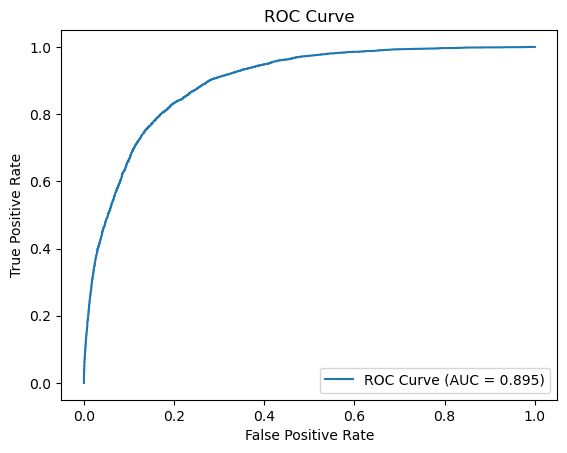

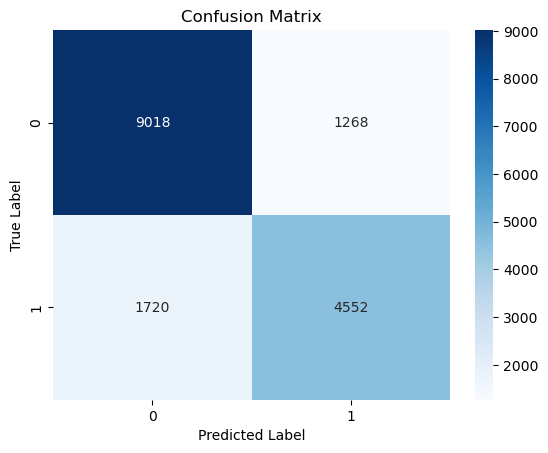

In [10]:
# Additional Model Evaluation Metrics


# Stratified 5-Fold Cross Validation Accuracy on reduced features
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=41)
scores = cross_val_score(pipe, X_train_new, y_train, cv=cv, scoring='accuracy')
print("Cross-validation accuracy scores (7 features):", scores)
print("Mean accuracy:", scores.mean())

# ROC Curve and AUC Score
y_proba = pipe.predict_proba(X_test_new)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC AUC Score:", roc_auc)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()